# Case7-challenge00f_rDK

Modified version from Case7-0challengef by T. Kamizuka. 

In this note, we estimate the field parameters and sky coordinates of objects from the observed positions on the focal plane and pointing information. The pointing positions are not variables in this note. When they are treated as variables, they converge to strange values (see Case7-challenge00a). The SIP-convention distortion is considered in this note.

## Preparation

At first, we add the analysis directry to the python path.

In [1]:
import sys
# sys.path.append('/Users/dkawata/work/obs/projs/JASMINE-Mission/analysis-testing-e2e/jasmine_warpfield/challenge/case7')

Next, we load the data.

In [2]:
import astropy.io.ascii as asc
import astropy.units as u

objects = asc.read('/Users/dkawata/work/obs/projs/JASMINE-Mission/analysis-testing-e2e/jasmine_warpfield/challenge/case7/case7_challenge_00.txt') #consists of x (um), y (um), catalog_id, ra (deg), dec (deg), and field.
pointings = asc.read('/Users/dkawata/work/obs/projs/JASMINE-Mission/analysis-testing-e2e/jasmine_warpfield/challenge/case7/case7_challenge_00_pointing.txt') # consists of field, ra (deg), dec (deg), and pa (deg).

We convert the units of x and y from um to pix with assuming the pixel size to be 15 um.

In [3]:
pix_size = 15.*u.um
objects['x'] = (objects['x']/pix_size).si
objects['y'] = (objects['y']/pix_size).si
# objects: x (px), y (px), catalog_id, ra (deg), dec (deg), and field.
# pointings: field, ra (deg), dec (deg), and pa (deg).

Then, we change the ids for easy handling.

In [4]:
from astropy.table import unique
import numpy as np

ids = unique(objects, keys='catalog_id')['catalog_id']
objects.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(objects['catalog_id']==ids[i])
    objects['id'][pos] = i

objects.remove_column('catalog_id')
objects.rename_column('id', 'catalog_id')

Here, we make some arrays for further analysis. One new array is true_radec which stores true ra/dec values. Duplicated information (rows for the same object) is removed, and the rows are sorted with object ids. Another new array is observed_xy. It contains field ids, observed x/y positions on the focal plane, catalog ids, and estimated ra/dec values instead of true ra/dec values. The estimated ra/dec values are initialized to be zero at this moment.

In [5]:
true_radec = objects['catalog_id', 'ra', 'dec'].copy()
true_radec.sort('catalog_id')
true_radec = unique(true_radec, keys='catalog_id') # consists of catalog_id, ra (deg), and dec (deg).

observed_xy = objects['field', 'x', 'y', 'catalog_id', 'ra', 'dec'].copy()
observed_xy.rename_column('ra', 'ra_est')
observed_xy.rename_column('dec', 'dec_est')
# observed_xy will have field, x (px), y (px), catalog_id, and estimated ra/dec (deg).

# initializing ra_est and dec_est
observed_xy['ra_est']  = 0.0
observed_xy['dec_est'] = 0.0

In addition, we make another array which stores field parameters. The plate scale is assumed to be the same value for all plates. At this time, an approximated value is stored in a variable (plate_scale).

In [6]:
field_params = pointings.copy() # field, ra (deg), dec (deg), and pa (deg).
# field_params['pa'] -= 240.0 # offset?
plate_scale = 8.e-6*u.deg*(pix_size/u.um).si # in deg/pix

Let's check the object distribution on sky.

Text(0, 0.5, 'dec (deg)')

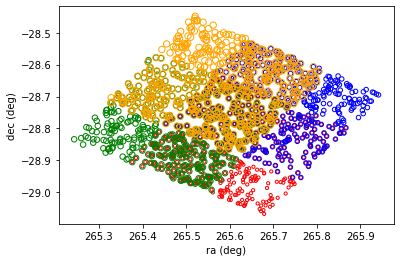

In [7]:
import matplotlib.pylab as plt
import numpy as np

color = ['red', 'blue', 'green', 'orange']

for i in range(0, np.max(field_params['field'])+1):
    pos = np.where(objects['field']==i)
    plt.scatter(objects['ra'][pos], objects['dec'][pos], marker='o', facecolor='None', edgecolor=color[i], s=10*i+10)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')

We can see that the data consists of four regions and that the overlapped region has a size of about a 1/4 FoV.

We select the objects in the overlapped region for further analysis.

In [8]:
true_radec_overlap = true_radec.copy()
observed_xy_overlap = observed_xy.copy()
for cid in true_radec['catalog_id']:
    if np.count_nonzero(observed_xy['catalog_id']==cid)!=4:
    # if np.count_nonzero(observed_xy['catalog_id']==cid)<=1:
        pos = np.where(true_radec_overlap['catalog_id']==cid)[0]
        true_radec_overlap.remove_rows(pos)
        pos = np.where(observed_xy_overlap['catalog_id']==cid)[0]
        observed_xy_overlap.remove_rows(pos)

Let's check the distribution of the selected objects.

225


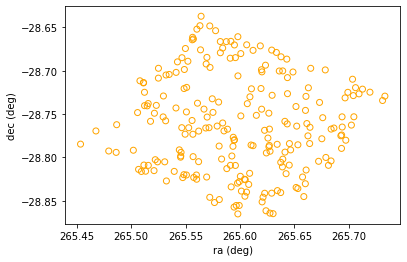

In [9]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='o', facecolor='None', edgecolor='orange')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
print(len(true_radec_overlap['ra']))

These objects will be used for the following analysis.

We again modify the catalog id for easy handling.

In [10]:
ids = unique(true_radec_overlap, keys='catalog_id')['catalog_id']
true_radec_overlap.add_column(-1, name='id')
observed_xy_overlap.add_column(-1, name='id')
for i in range(0, np.size(ids)):
    pos = np.where(true_radec_overlap['catalog_id']==ids[i])
    true_radec_overlap['id'][pos] = i
    pos = np.where(observed_xy_overlap['catalog_id']==ids[i])
    observed_xy_overlap['id'][pos] = i

true_radec_overlap.remove_column('catalog_id')
true_radec_overlap.rename_column('id', 'catalog_id')
observed_xy_overlap.remove_column('catalog_id')
observed_xy_overlap.rename_column('id', 'catalog_id')

## First guess of the positions

At first, we define a wcs constructor.

In [11]:
from astropy.wcs import WCS
from astropy.wcs import Sip
import astropy.units as u

def wcs(ra_ptg, dec_ptg, pa_ptg, scale, a=None, b=None, ap=None, bp=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale, scale])
    w.wcs.crval=[ra_ptg, dec_ptg]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa_ptg*u.deg), -np.sin(pa_ptg*u.deg)],
              [np.sin(pa_ptg*u.deg), np.cos(pa_ptg*u.deg)]]
#    if a is not None and b is not None:
    w.sip = Sip(a, b, ap, bp, [0, 0])
    
    return w

Then, we estimate the sky coordinates from the observed focal-plane positions and (approximated) field parameters.

In [12]:
for i in range(0, np.size(field_params)):
    fp = field_params[i]
    w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale.value)
    pos = np.where(observed_xy_overlap['field']==fp['field'])
    ret = w.all_pix2world(np.concatenate(([observed_xy_overlap[pos]['x']], [observed_xy_overlap[pos]['y']])).T, 0)
    observed_xy_overlap['ra_est'][pos]  = ret[:, 0]
    observed_xy_overlap['dec_est'][pos] = ret[:, 1]

Let's check the true positions and estimated positions.

 number of stars used = 900


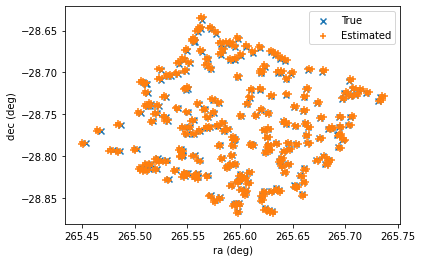

In [13]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(observed_xy_overlap['ra_est'], observed_xy_overlap['dec_est'], marker='+', label='Estimated')
print(' number of stars used =', len(observed_xy_overlap['ra_est']))
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

Here, there are four estimated positions for each object. We take their mean values as the first-guess positions and store them in radec_est array.

In [14]:
from astropy.table import Table

radec_est = Table(names=['catalog_id', 'ra_est', 'dec_est'], \
            dtype=['int64', 'float64', 'float64'])
#           units=[None, u.deg, u.deg], \
#           dtype=['int64', 'float64', 'float64'])

radec_est['ra_est'].unit = u.deg
radec_est['dec_est'].unit = u.deg

cat_ids = unique(observed_xy_overlap, 'catalog_id')['catalog_id']

for i in cat_ids:
    pos = np.where(observed_xy_overlap['catalog_id'] == i)
    ra = np.mean(observed_xy_overlap[pos]['ra_est'])*u.deg
    dec = np.mean(observed_xy_overlap[pos]['dec_est'])*u.deg
    radec_est.add_row([i, ra, dec])
    
print('radec_est=', radec_est)


radec_est= catalog_id       ra_est             dec_est      
                  deg                 deg        
---------- ------------------ -------------------
         0  265.6308876339052 -28.866988971899108
         1 265.62424297966515 -28.863572235415788
         2 265.59786205586573 -28.867279870863182
         3  265.5943200612991   -28.8592512967087
         4  265.5963997467211 -28.857367218146447
         5 265.59917258362975 -28.857352038828637
         6 265.60450065366143 -28.846464217814823
         7 265.62060493590286 -28.853126093076998
         8  265.6279629253354  -28.86634320317342
         9  265.6380060496645 -28.842148861602087
       ...                ...                 ...
       215 265.54554522043077  -28.68345433135085
       216 265.54876920031154 -28.672622839642724
       217  265.5552138362627 -28.662369072274615
       218  265.5562500609225 -28.661426955446384
       219 265.55551355164573 -28.659444560057295
       220  265.5715848370132  -28.6460

Let's check the estimated positions.

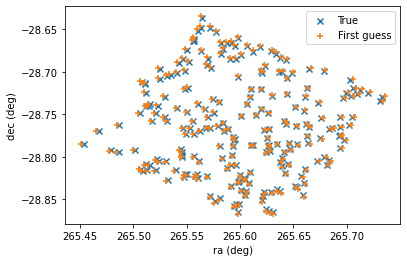

In [15]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='First guess')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.legend()

## Parameter adjustment

At first, we define a function which calculates x/y positions from the ra/dec values estimated above and the field/catalog ids.

In [16]:
def xy_calculator(observed_xy, field_params, plate_scale, ap, bp, radec_info):
    # observed_xy:  consists of field, x (px), y (px), catalog_id, ra_est (deg), and dec_est(deg).
    # field_params: consists of field, ra (deg), dec (deg), and pa (deg).
    # radec_info:   consists of catalog_id, ra_est (deg), and dec_est (deg).

    observed_xy_cp = observed_xy.copy()
    observed_xy_cp.rename_column('x', 'x_est')
    observed_xy_cp.rename_column('y', 'y_est')
    observed_xy_cp['x_est']   = None
    observed_xy_cp['y_est']   = None
    observed_xy_cp['ra_est']  = None
    observed_xy_cp['dec_est'] = None

    for i in range(0, np.size(radec_info)):
        pos = np.where(observed_xy_cp['catalog_id']==radec_info[i]['catalog_id'])
        observed_xy_cp['ra_est'][pos]  = radec_info[i]['ra_est']
        observed_xy_cp['dec_est'][pos] = radec_info[i]['dec_est']
    
    for i in range(0, np.size(field_params)):
        fp = field_params[i]
        w = wcs(fp['ra'], fp['dec'], fp['pa'], plate_scale, ap=ap, bp=bp)
        pos = np.where(observed_xy_cp['field']==fp['field'])
        radec0 = np.concatenate(([observed_xy_cp[pos]['ra_est']], [observed_xy_cp[pos]['dec_est']])).T
        ret = w.sip_foc2pix(w.wcs_world2pix(radec0, 0)-w.wcs.crpix, 0)
        observed_xy_cp['x_est'][pos] = ret[:, 0]
        observed_xy_cp['y_est'][pos] = ret[:, 1]

    return observed_xy_cp['x_est', 'y_est']

Then, we define a model function to be used in the least-square calculation.

In [17]:
def model(params, ra_ptgs, dec_ptgs, n_fields, n_objects, dim_sip, observed_xy):
    # params = (pa_ptg..., scale, a..., b..., ra_obj..., dec_obj)
    pa_ptgs, scale, ap, bp, ra_objs, dec_objs =\
        np.split(params, [n_fields, n_fields+1,\
                          n_fields+1+(dim_sip+1)**2, n_fields+1+2*(dim_sip+1)**2,\
                          n_fields+1+2*(dim_sip+1)**2+n_objects])
    
    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    
    ap_matrix = np.reshape(ap, (dim_sip+1, dim_sip+1))
    bp_matrix = np.reshape(bp, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1)))    
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0

    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    ap_matrix = ap_matrix * (1.e-3**mn)
    bp_matrix = bp_matrix * (1.e-3**mn)
    
    radec_info = Table(data=[ra_objs, dec_objs, -np.ones(shape=(np.size(ra_objs)))],\
                       names=['ra_est', 'dec_est', 'catalog_id'],\
                       dtype=['float64', 'float64', 'int64'])
#                       units=[u.deg, u.deg, None],\
#                       dtype=['float64', 'float64', 'int64'])
    radec_info['ra_est'].unit = u.deg
    radec_info['dec_est'].unit = u.deg
    
    field_params['field'] = np.arange(0, np.size(field_params))
    radec_info['catalog_id'] = np.arange(0, np.size(radec_info))
    
    ret = xy_calculator(observed_xy, field_params, scale[0], ap_matrix, bp_matrix, radec_info)

    return np.concatenate((ret['x_est'], ret['y_est']))

Next, we execute the least-square calculation to derive the field parameters and sky positions of the objects in the overlapped region.

### Using scipy.optimize least_squares.

Redefine model to solve.

In [18]:
def model_func(params, ra_ptgs, dec_ptgs, n_fields, n_objects, dim_sip, observed_xy, measured_xy):
    # params = (pa_ptg..., scale, a..., b..., ra_obj..., dec_obj)
    pa_ptgs, scale, ap, bp, ra_objs, dec_objs =\
        np.split(params, [n_fields, n_fields+1,\
                          n_fields+1+(dim_sip+1)**2, n_fields+1+2*(dim_sip+1)**2,\
                          n_fields+1+2*(dim_sip+1)**2+n_objects])
    
    field_params = Table(data=[ra_ptgs, dec_ptgs, pa_ptgs, -np.ones(shape=(np.size(ra_ptgs)))],\
                         names=['ra', 'dec', 'pa', 'field'],\
                         dtype=['float64', 'float64', 'float64', 'int64'])
#                         names=['ra', 'dec', 'pa', 'field'],\
#                         units=[u.deg, u.deg, u.deg, None],\
#                         dtype=['float64', 'float64', 'float64', 'int64'])
    field_params['ra'].unit = u.deg
    field_params['dec'].unit = u.deg
    field_params['pa'].unit = u.deg
    
    ap_matrix = np.reshape(ap, (dim_sip+1, dim_sip+1))
    bp_matrix = np.reshape(bp, (dim_sip+1, dim_sip+1))
    
    # mns = np.concatenate(((0, 1), np.arange(dim_sip+1, 2*(dim_sip)+1))) 
    # for mn in mns:
    #    for m in range(np.max([0, mn-dim_sip]), np.min([mn+1, dim_sip+1])):
    #        n = mn - m
    #        ap_matrix[m, n] = 0
    #        bp_matrix[m, n] = 0

    m, n = np.indices((dim_sip+1, dim_sip+1))
    mn = m + n
    ap_matrix = ap_matrix * (1.e-3**mn)
    bp_matrix = bp_matrix * (1.e-3**mn)
    
    radec_info = Table(data=[ra_objs, dec_objs, -np.ones(shape=(np.size(ra_objs)))],\
                       names=['ra_est', 'dec_est', 'catalog_id'],\
                       dtype=['float64', 'float64', 'int64'])
#                       units=[u.deg, u.deg, None],\
#                       dtype=['float64', 'float64', 'int64'])
    radec_info['ra_est'].unit = u.deg
    radec_info['dec_est'].unit = u.deg
    
    field_params['field'] = np.arange(0, np.size(field_params))
    radec_info['catalog_id'] = np.arange(0, np.size(radec_info))
    
    ret = xy_calculator(observed_xy, field_params, scale[0], ap_matrix, bp_matrix, radec_info)
    
    residuals = np.concatenate((ret['x_est'], ret['y_est']))-measured_xy

    return residuals

In [52]:
from scipy.optimize import least_squares
import time

dim_sip = 4
ap = np.zeros(shape=(dim_sip+1, dim_sip+1))
bp = np.zeros(shape=(dim_sip+1, dim_sip+1))

# constructing a_init (initial parameter set).
a_init = np.array(np.concatenate((field_params['pa'], [plate_scale.value], ap.flatten(), bp.flatten(),\
                                  radec_est['ra_est'], radec_est['dec_est']))) # This must be an ndarray.
print(' # of fitting parameters =', len(a_init))
# constraining ra/dec values in 'observed' between -180 and 180 deg.
measured = np.concatenate((observed_xy_overlap['x'], observed_xy_overlap['y']))
print(' # of data points =', len(measured))
#pos = np.where(measured>180.)
#measured[pos] -= 360.
#pos = np.where(measured<-180.)
#measured[pos] += 360.

start = time.time()
result = least_squares(model_func, a_init, loss='linear', args=(field_params['ra'], field_params['dec'],\
                                 np.size(field_params), np.size(radec_est), dim_sip, observed_xy_overlap, measured), \
                      verbose=2)
print(' time=',time.time()-start)

## pa should be a positive value between 0 and 360.
#if result[3] < 0:
#    result[3] = -result[3]
#    result[2] = result[2] + 180.0
#
#if result[2] > 360.0 or result[2] < 0.0:
#    result[2] = result[2]%360.0

 # of fitting parameters = 505
 # of data points = 1800
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0235e+05                                    8.85e+10    
       1              2         3.9241e+01      1.02e+05       4.05e+03       1.79e+09    
       2              3         4.7034e-06      3.92e+01       8.11e+03       3.41e+05    
       3              7         1.1027e-07      4.59e-06       2.53e+02       5.26e+04    
       4              8         1.1522e-10      1.10e-07       5.07e+02       1.33e+03    
       5             10         5.1094e-13      1.15e-10       2.53e+02       1.47e+02    
       6             13         1.9087e-13      3.20e-13       3.17e+01       1.61e+02    
       7             14         4.4430e-16      1.90e-13       6.33e+01       7.46e+00    
       8             18         4.9143e-17      3.95e-16       1.98e+00       1.82e+00    
       9             21         2.

### Checking results

#### Preparation

In [53]:
n_fields = np.size(field_params)
n_objects = np.size(radec_est)
ra_ptgs = field_params['ra']
dec_ptgs= field_params['dec']
pa_ptgs, scale, ap, bp, ra_objs, dec_objs =\
    np.split(result.x, [n_fields, n_fields+1,\
                      n_fields+1+(dim_sip+1)**2, n_fields+1+2*(dim_sip+1)**2,\
                      n_fields+1+2*(dim_sip+1)**2+n_objects])

#### Scale (deg/pix)

In [54]:
scale

array([0.00011777])

In [55]:
print(' true scale =',7.848716680726079e-06*u.deg*(pix_size/u.um).si,'/pix')

 true scale = 0.00011773075021089118 deg /pix


#### Position angle (deg)

In [56]:
pa_ptgs

array([301.82639602, 301.8307496 , 301.22205194, 303.6336692 ])

#### Object positions

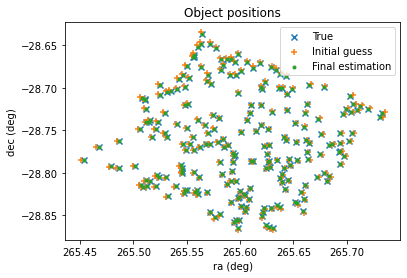

In [57]:
plt.scatter(true_radec_overlap['ra'], true_radec_overlap['dec'], marker='x', label='True')
plt.scatter(radec_est['ra_est'], radec_est['dec_est'], marker='+', label='Initial guess')
plt.scatter(ra_objs, dec_objs, marker='.', label='Final estimation')
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('Object positions')
plt.legend()

#### AP/BP matrices (must be scaled as described in the model function)

In [58]:
np.reshape(ap, (dim_sip+1, dim_sip+1))

array([[ 9.33333328e-01,  3.94695146e-01, -3.50529601e-02,
         6.82238126e-07,  2.31352399e-11],
       [ 3.32447597e-01,  2.37011149e-01,  1.72941677e-03,
        -1.22900092e-08, -2.42373199e+03],
       [-7.05616060e-02,  1.22061575e-03, -1.56611426e-05,
        -3.97259170e+02, -3.14003143e+03],
       [-4.81974045e-07,  1.23653372e-08,  1.99541951e+02,
        -6.78895195e+02, -1.62968237e+03],
       [ 8.44733138e-11,  3.79829862e+02, -3.41153846e+03,
         4.03585504e+02, -3.12995519e+03]])

In [59]:
np.reshape(bp, (dim_sip+1, dim_sip+1))

array([[ 9.33333335e-01,  3.32497900e-01, -2.87216034e-01,
        -9.00378172e-07, -3.81037573e-11],
       [-3.94706941e-01, -8.41347760e-02, -2.28275045e-03,
        -3.76498123e-08, -6.97283843e+02],
       [ 4.72018401e-02, -2.04328535e-03, -4.77286429e-05,
        -2.05873094e+03, -9.04688781e+02],
       [ 8.06585289e-07,  3.76548991e-08,  1.18945934e+03,
         1.83228542e+03,  3.88234964e+03],
       [-2.15309381e-11,  1.38495311e+02,  1.61110446e+03,
        -2.14691650e+03,  1.77912149e+03]])

#### Position difference

In [60]:
from astropy.coordinates import SkyCoord

distlist = []
for i in range(0, np.size(ra_objs)):
    c1 = SkyCoord(ra_objs[i]*u.deg, dec_objs[i]*u.deg)
    c2 = SkyCoord(true_radec_overlap['ra'][i]*u.deg, true_radec_overlap['dec'][i]*u.deg)
    distlist.append(c1.separation(c2).arcsec)
distlist = np.array(distlist)

Text(0, 0.5, 'Number')

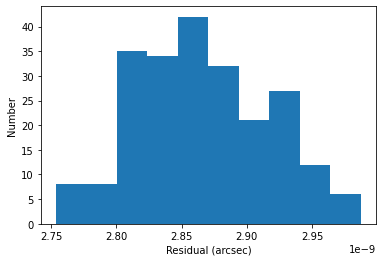

In [61]:
#plt.hist(np.log10(distlist))
plt.hist(distlist)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Number")

Text(0, 0.5, 'dDEC (arcsec)')

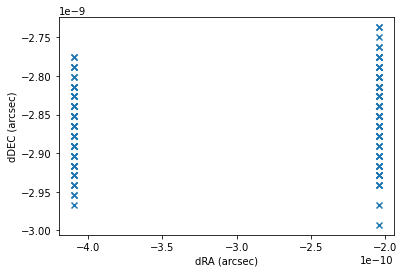

In [62]:
dra = ((ra_objs-true_radec_overlap['ra']).data)*u.deg
ddec = ((dec_objs-true_radec_overlap['dec']).data)*u.deg
dra_arcsec = dra.to_value(u.arcsec)
ddec_arcsec = ddec.to_value(u.arcsec)
plt.scatter(dra_arcsec, ddec_arcsec, marker='x')
plt.xlabel('dRA (arcsec)')
plt.ylabel('dDEC (arcsec)')
#plt.xlim([-0,8, 0.0])
#plt.ylim([-0.8, 0.0])

#### Residual in focal-plane positions

 size =  900


Text(0, 0.5, 'dy (pix)')

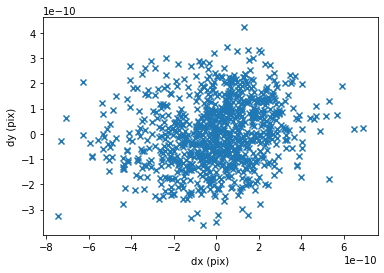

In [63]:
ret = model(result.x, field_params['ra'], field_params['dec'], n_fields, n_objects, dim_sip, observed_xy_overlap)
print(' size = ',np.size(observed_xy_overlap['x']))
nstar=len(observed_xy_overlap['ra_est'])
dx = ret[0:nstar] - observed_xy_overlap['x']
dy = ret[nstar:nstar*2] - observed_xy_overlap['y']
#plt.scatter(observed_xy_overlap['x'], observed_xy_overlap['y'], marker='+')
#plt.scatter(ret[0:900], ret[900:1800], marker='x')
plt.scatter(dx, dy, marker='x')
plt.xlabel('dx (pix)')
plt.ylabel('dy (pix)')
#plt.xlim([-0.1, 0.1])
#plt.ylim([-0.1, 0.1])